In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
sns.set_style('whitegrid')
import re
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
%matplotlib inline

# Numerical Analysis

**Reliance Industries Stock Prices**

In [3]:
df = pd.read_csv('./RELIANCE.NS.csv')
prediction = pd.read_csv('./jan_rel.csv')

In [3]:
df = df.fillna(method='ffill')

In [30]:
df.sample(10)

,Date,Open,High,Low,Close,Adj Close,Volume
1512,2006-11-20,303.436218,313.998596,303.436218,311.794495,278.949493,11253679.0
4531,2019-02-07,1297.946777,1308.793945,1274.023560,1278.283203,1266.487793,9299549.0
4196,2017-10-03,787.534973,796.301880,777.975586,790.853516,778.753479,8466559.0
850,2004-04-06,89.122261,90.112503,87.366119,89.029427,75.640678,46162334.0
2645,2011-06-21,416.006683,423.485779,414.718872,420.340576,389.253448,8036440.0
2175,2009-07-31,474.254547,489.088928,473.325836,484.259705,439.001862,14100305.0
881,2004-05-19,68.737091,72.102386,68.737091,70.005844,59.477978,74454223.0
838,2004-03-19,79.993416,81.780502,79.993416,80.960457,68.785164,50647322.0
2989,2012-11-08,392.776855,395.401978,391.167114,394.559967,369.830566,5729271.0
2484,2010-10-27,543.844910,549.788574,536.539124,541.244568,496.984558,10128334.0


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

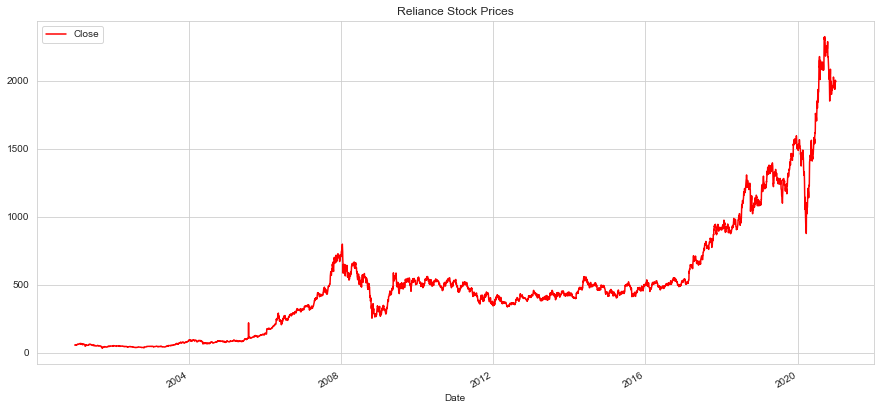

In [8]:
ax = df.plot(y='Close',figsize=(15,7),color='Red',title='Reliance Stock Prices')

## Applying GBM using Monte Carlo Simulation 

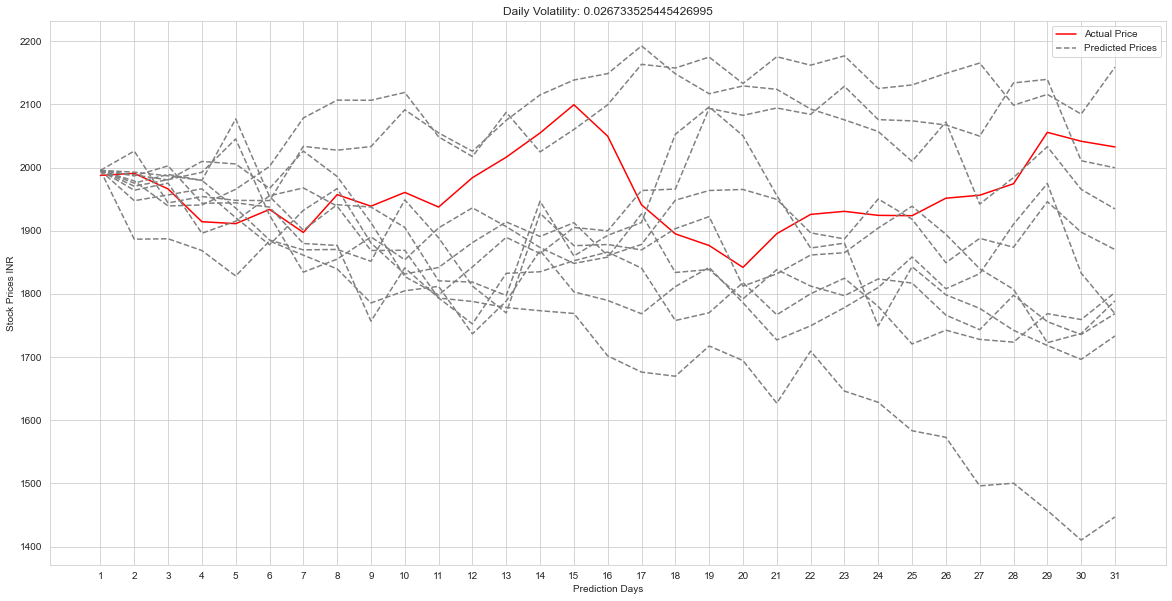

In [19]:
col = 'Close'
s0 = df.iloc[4996,3]
dt = 1
T = 30 
N=T/dt
t = np.arange(1, int(N) + 1)
returns = (df.loc[df.index[1]:, col] - df.shift(1).loc[df.index[1]:, col]) / df.shift(1).loc[df.index[1]:, col]
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 10
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
drift = 0
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
S = np.array([s0 * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[s0] for scen in range(scen_size)]), S))
plt.figure(figsize = (20,10))
x= np.arange(1,32)

actual = np.array(prediction['Close'])
plt.plot(x,actual,color='red')
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(x, S[i, :],'--',color='grey')
    plt.xticks(x)
    plt.ylabel('Stock Prices INR')
    plt.xlabel('Prediction Days')

plt.legend(('Actual Price','Predicted Prices'))
plt.show()

**Stock Prices does follow Geometric Brownian Motion but are also affected by other different factors which are not covered in Mathematical Model.**

In [20]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(price):
    result=adfuller(price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [21]:
adfuller_test(df['Close'])

ADF Test Statistic : 1.109591794371281
p-value : 0.9952976589576928
#Lags Used : 31
Number of Observations Used : 4965
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [22]:
SPLIT = 0.8
train = df.iloc[:int(SPLIT*len(df)),3]
val = df.iloc[int(SPLIT*len(df)):,3]

In [23]:
print(train.shape,val.shape)

(3997,) (1000,)


## Using Auto Arima (Auto regressive Integrated Moving Average)

In [24]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=28290.049, Time=10.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28323.735, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28325.721, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28325.721, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28322.491, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28312.992, Time=2.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28311.785, Time=3.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=28301.654, Time=7.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=28303.322, Time=7.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28327.720, Time=1.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=28301.976, Time=4.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=28299.830, Time=3.65 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=28297.677, Time=7.86 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=28281.178, Time=5.07 sec
 ARIMA(1,1,2)(0,0,

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

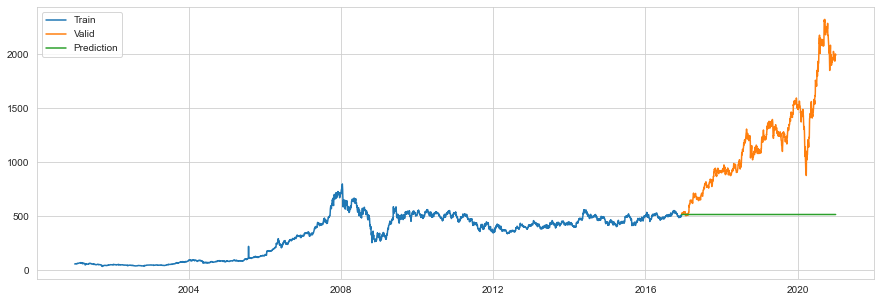

In [25]:
forecast = model.predict(n_periods=len(val))
forecast = pd.DataFrame(forecast,index = val.index,columns=['Prediction'])
plt.figure(figsize=(15,5))
plt.plot(train, label='Train')
plt.plot(val, label='Valid')
plt.plot(forecast, label='Prediction')
plt.legend(('Train','Valid','Prediction'))
plt.show()

In [26]:
rms = np.sqrt(mean_squared_error(val,forecast))
print(f'Root Mean Square Error :{rms}')

Root Mean Square Error :807.5697406551978


## Using FB Prophet

In [32]:
df = df.loc[:,['Date','Close']]

In [33]:
df.rename(columns = {'Date':'ds','Close':'y'}, inplace = True)

In [34]:
df['ds'] = pd.to_datetime(df['ds'])

In [35]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
future_dates=model.make_future_dataframe(periods=31)

In [37]:
future_dates

,ds
0,2001-01-02
1,2001-01-03
2,2001-01-04
3,2001-01-05
4,2001-01-08
...,...
5023,2021-01-26
5024,2021-01-27
5025,2021-01-28
5026,2021-01-29


In [38]:
prediction=model.predict(future_dates)

In [39]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-02,53.692429,-43.482713,166.225014,53.692429,53.692429,2.272633,2.272633,2.272633,4.440342,4.440342,4.440342,-2.167709,-2.167709,-2.167709,0.0,0.0,0.0,55.965061
1,2001-01-03,53.669590,-51.079051,155.319727,53.669590,53.669590,1.648602,1.648602,1.648602,3.777312,3.777312,3.777312,-2.128710,-2.128710,-2.128710,0.0,0.0,0.0,55.318192
2,2001-01-04,53.646751,-46.110024,162.090143,53.646751,53.646751,2.383165,2.383165,2.383165,4.433116,4.433116,4.433116,-2.049951,-2.049951,-2.049951,0.0,0.0,0.0,56.029916
3,2001-01-05,53.623912,-49.521455,156.065633,53.623912,53.623912,1.044002,1.044002,1.044002,2.983068,2.983068,2.983068,-1.939066,-1.939066,-1.939066,0.0,0.0,0.0,54.667914
4,2001-01-08,53.555395,-50.167481,156.883364,53.555395,53.555395,1.626526,1.626526,1.626526,3.130094,3.130094,3.130094,-1.503568,-1.503568,-1.503568,0.0,0.0,0.0,55.181921


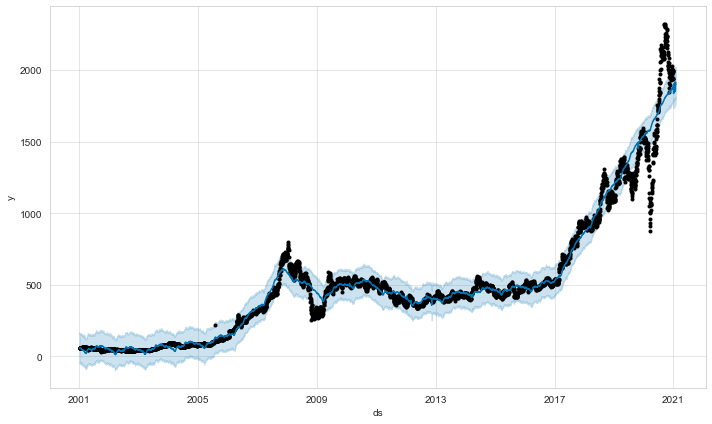

In [40]:
model.plot(prediction);

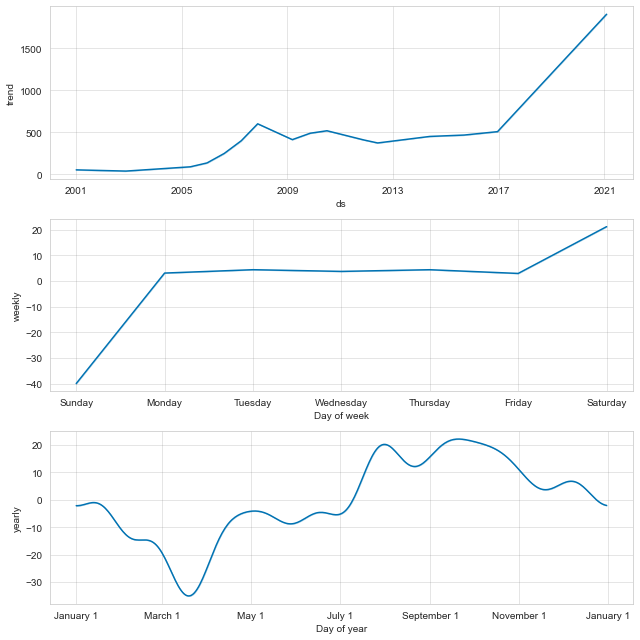

In [41]:
model.plot_components(prediction);

In [42]:
df_cv = cross_validation(model, initial='1200 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 32 forecasts with cutoffs between 2004-09-20 00:00:00 and 2019-12-31 00:00:00


  0%|          | 0/32 [00:00<?, ?it/s]

In [43]:
df_p = performance_metrics(df_cv)

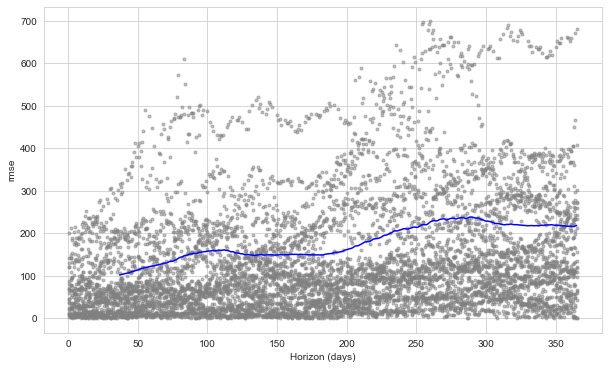

In [44]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

## Textual Analysis

In [23]:
news = pd.read_csv('./india-news-headlines.csv')

In [24]:
news.sample(10)

,publish_date,headline_category,headline_text
1719323,20130928,city.hyderabad,Nandyal MP joins YSR Congress Party
2776535,20171121,city.chennai,Light rain; cloudy skies expected today: Met
1276604,20111231,city.kozhikode,Tile workers call off indefinite strike
3219541,20191118,city.varanasi,Varanasi Municipal Corporation app to check re...
1748766,20131109,assembly-elections-2013.delhi-assembly-elections,Poll process in Delhi starts with issue of not...
1680627,20130804,unknown,Greater Noida West offers ample choices to mid...
3287893,20200403,city.mysuru,Nine people in Nanjangud display symptoms; war...
510856,20070930,entertainment.english.hollywood,Crowe blames low self-esteem
1572416,20130301,business.india-business,Union Budget 2013: Simply Unaffordable Vehicles?
291359,20040409,world.us,UN concerned with developments in Iraq


In [25]:
print(news.shape)

(3424067, 3)


In [26]:
news.iloc[0,2]

'Status quo will not be disturbed at Ayodhya; says Vajpayee'

In [27]:
news.iloc[12312,2]

'Govt holds fast to no-neera policy'

In [28]:
def preprocess(text):
    '''
    Function makes all the text lower case 
    Expanding contractions can't ==> cannot
    Removing everything except alphabets

    '''
    text = text.lower();
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    
    return text
    

In [29]:
news['headline_text'] = news['headline_text'].apply(lambda x:preprocess(x))

In [34]:
news['publish_date'] = pd.to_datetime(news['publish_date'],format='%Y%m%d')

In [64]:
new_df = news.drop_duplicates(['headline_text'])

In [68]:
k = new_df.groupby(['publish_date'])['headline_text'].apply(lambda x:' '.join(x)).reset_index()

In [80]:
k = k.rename(columns={'publish_date': 'Date'})

In [88]:
df['Date'] = pd.to_datetime(df['Date'])

In [89]:
res =  k.merge(df,on=['Date'],how='inner')

In [93]:
res.to_csv('train.csv',index=False)

In [2]:
res = pd.read_csv('./train.csv')

In [4]:
res.head()

,Date,headline_text,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,status quo will not be disturbed at ayodhya s...,52.661041,55.546684,52.645569,54.819473,42.954815,42810928.0
1,2001-01-03,powerless north india gropes in the dark think...,54.927780,55.964447,54.618328,55.709148,43.651936,57159622.0
2,2001-01-04,the string that pulled stephen hawking to indi...,55.562157,56.769024,55.113453,55.361015,43.379154,38666386.0
3,2001-01-05,light combat craft takes india into club class...,55.159870,56.753551,55.159870,56.366734,44.167198,48215173.0
4,2001-01-08,sangh parivar babri panel up the ante frontru...,56.088226,56.854122,55.275913,55.732357,43.670128,44224788.0


In [5]:
res = res.drop(columns=['Open','High','Low','Adj Close','Volume'])

In [19]:
indicator = []
for i in range(len(res)):
    if i==len(res)-1:
        indicator.append(0)
    else :
        if res['Close'][i] < res['Close'][i+1]:
            indicator.append(1)
        else:
            indicator.append(0)

In [20]:
indicator = pd.DataFrame(indicator,columns=['indicator'])

In [22]:
new_df = pd.concat([res,indicator],axis=1)

In [26]:
new_df.head()

,Date,headline_text,Close,indicator
0,2001-01-02,status quo will not be disturbed at ayodhya s...,54.819473,1
1,2001-01-03,powerless north india gropes in the dark think...,55.709148,0
2,2001-01-04,the string that pulled stephen hawking to indi...,55.361015,1
3,2001-01-05,light combat craft takes india into club class...,56.366734,0
4,2001-01-08,sangh parivar babri panel up the ante frontru...,55.732357,0


In [27]:
new_df.to_csv('train.csv',index=False)

## Indicator Model

In [2]:
df = pd.read_csv('train.csv')

In [5]:
# Splitting the data into train and test 
SPLIT  = 0.7
train  = df.iloc[:int(len(df)*SPLIT),:]
test  = df.iloc[int(len(df)*SPLIT):,:]

In [7]:
print(len(train),len(test))

3476 1491


In [25]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

In [101]:
train  = pd.read_csv('train_folds.csv')
test = pd.read_csv('test.csv')

In [6]:
stop_words = set(stopwords.words('english'))
tk = RegexpTokenizer('\s+', gaps = True)
ps = PorterStemmer()
def text_process(text):
    word = tk.tokenize(text)
    filtered_sentence = [w for w in word if not w in stop_words]
    sentence = [ps.stem(w) for w in filtered_sentence]
    text = ' '.join(w for w in sentence)
    return text

In [19]:
train['headline_text'] = train['headline_text'].apply(lambda x: text_process(x))

In [20]:
test['headline_text'] = test['headline_text'].apply(lambda x: text_process(x))

In [9]:
def create_folds(df):
    '''
    Function to create Stratified K Fold
    Input = Dataframe
    Output = NULL
    '''
    df['kfold'] = -1
    df = df.sample(frac=1).reset_index(drop=True)
    y = df.indicator.values
    
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
        df.loc[v_,'kfold'] = f
        
        
    df.to_csv('train_folds.csv',index=False)
    return df

In [27]:
create_folds(train)

,Date,headline_text,Close,indicator,kfold
0,2004-05-21,sacr spacebrpow posit poison speak treebrpric ...,68.002136,1,0
1,2005-01-27,hey ram bhagat azad label terrorist custodi co...,78.306900,1,0
2,2004-02-09,hc decid sit chief puri fate bilki case salt f...,91.087280,1,0
3,2012-03-23,abhi ash swap role prakash raj zanjeer remak c...,368.531677,0,0
4,2011-04-28,john ranbir yrf next music launch gandhi hitle...,481.634583,1,0
...,...,...,...,...,...
3471,2003-11-04,hey sexi ladi enough reach mass sacr spacebrgo...,76.047897,0,4
3472,2003-06-13,monsoon set goa weekend want peopl believ hock...,48.421547,0,4
3473,2008-05-06,guid flirt latest hair trend summer I size zer...,656.279114,1,4
3474,2010-11-22,kangna enjoy singl vidya balan dirti pictur I ...,501.372498,0,4


In [19]:
models = {
    
    'rf':RandomForestClassifier(),
    'lr':LogisticRegression(),
    'gnb':GaussianNB()
    
}

In [31]:
def run_folds(df,fold,model):
    '''
    Funtcion to train and predict on the models on the given fold
    Input : Dataframe,Integer,Model
    Output: NULL
    '''
    
    df_train = df[df.kfold!=fold].reset_index(drop=True)
    df_valid = df[df.kfold==fold].reset_index(drop=True)
    vectorizer = TfidfVectorizer(ngram_range=(2,2))
    x_train = vectorizer.fit_transform(df_train['headline_text'])
    y_train = df_train.indicator.values
    
    x_valid = vectorizer.transform(df_valid['headline_text'])
    y_valid = df_valid.indicator.values
    
    clf = models[model]
    
    clf.fit(x_train,y_train)
    train_preds = clf.predict(x_train)
    preds = clf.predict(x_valid)
    print(f'Fold:{fold}')
    print('Train Accuracy Score:{}'.format(accuracy_score(y_train, train_preds)))
    print('Validation Accuracy Score:{}'.format(accuracy_score(y_valid, preds)))
    print('*'*50)
    
    
  #  joblib.dump(clf,f'models/dt_{fold}_{model}.bin')
    
    return

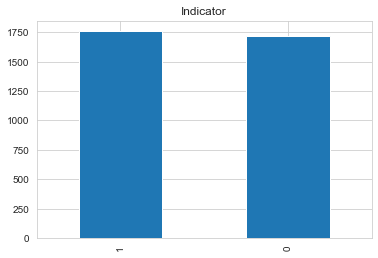

In [35]:
train['indicator'].value_counts().plot(kind='bar',title = 'Indicator')
plt.show()

In [5]:
train = train[['headline_text','indicator','kfold']]

## Unigram with BOW

In [13]:
for i in range(5):
    run_folds(train,i,'rf')

Fold0
Train Accuracy Score:1.0
Validation Accuracy Score:0.5129310344827587
**************************************************
Fold1
Train Accuracy Score:1.0
Validation Accuracy Score:0.5035971223021583
**************************************************
Fold2
Train Accuracy Score:1.0
Validation Accuracy Score:0.5151079136690647
**************************************************
Fold3
Train Accuracy Score:1.0
Validation Accuracy Score:0.516546762589928
**************************************************
Fold4
Train Accuracy Score:1.0
Validation Accuracy Score:0.479136690647482
**************************************************


In [15]:
for i in range(5):
    run_folds(train,i,'lr')

C:\Users\nishant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold:0
Train Accuracy Score:0.9996402877697842
Validation Accuracy Score:0.5100574712643678
**************************************************


C:\Users\nishant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold:1
Train Accuracy Score:0.9996404171161453
Validation Accuracy Score:0.5223021582733813
**************************************************


C:\Users\nishant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold:2
Train Accuracy Score:0.9996404171161453
Validation Accuracy Score:0.5079136690647482
**************************************************


C:\Users\nishant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold:3
Train Accuracy Score:0.9996404171161453
Validation Accuracy Score:0.48345323741007196
**************************************************
Fold:4
Train Accuracy Score:1.0
Validation Accuracy Score:0.5064748201438849
**************************************************


C:\Users\nishant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
for i in range(5):
    run_folds(train,i,'gnb')

Fold:1
Train Accuracy Score:0.9949658396260338
Validation Accuracy Score:0.4935251798561151
**************************************************
Fold:2
Train Accuracy Score:0.9946062567421791
Validation Accuracy Score:0.5179856115107914
**************************************************
Fold:3
Train Accuracy Score:0.9946062567421791
Validation Accuracy Score:0.48345323741007196
**************************************************
Fold:4
Train Accuracy Score:0.9942466738583243
Validation Accuracy Score:0.5064748201438849
**************************************************


## Bigram with BOW

In [26]:
for i in range(5):
    run_folds(train,i,'rf')

Fold:0
Train Accuracy Score:1.0
Validation Accuracy Score:0.5258620689655172
**************************************************
Fold:1
Train Accuracy Score:1.0
Validation Accuracy Score:0.520863309352518
**************************************************
Fold:2
Train Accuracy Score:1.0
Validation Accuracy Score:0.520863309352518
**************************************************
Fold:3
Train Accuracy Score:1.0
Validation Accuracy Score:0.5136690647482014
**************************************************
Fold:4
Train Accuracy Score:1.0
Validation Accuracy Score:0.5079136690647482
**************************************************


In [27]:
for i in range(5):
    run_folds(train,i,'lr')

Fold:0
Train Accuracy Score:1.0
Validation Accuracy Score:0.5043103448275862
**************************************************
Fold:1
Train Accuracy Score:1.0
Validation Accuracy Score:0.4892086330935252
**************************************************
Fold:2
Train Accuracy Score:1.0
Validation Accuracy Score:0.520863309352518
**************************************************
Fold:3
Train Accuracy Score:1.0
Validation Accuracy Score:0.4935251798561151
**************************************************
Fold:4
Train Accuracy Score:1.0
Validation Accuracy Score:0.516546762589928
**************************************************


## Bigram with tfidf

In [32]:
for i in range(5):
    run_folds(train,i,'rf')

Fold:0
Train Accuracy Score:1.0
Validation Accuracy Score:0.5229885057471264
**************************************************
Fold:1
Train Accuracy Score:1.0
Validation Accuracy Score:0.516546762589928
**************************************************
Fold:2
Train Accuracy Score:1.0
Validation Accuracy Score:0.5093525179856115
**************************************************
Fold:3
Train Accuracy Score:1.0
Validation Accuracy Score:0.5093525179856115
**************************************************
Fold:4
Train Accuracy Score:1.0
Validation Accuracy Score:0.5122302158273381
**************************************************


In [33]:
for i in range(5):
    run_folds(train,i,'lr')

Fold:0
Train Accuracy Score:1.0
Validation Accuracy Score:0.521551724137931
**************************************************
Fold:1
Train Accuracy Score:1.0
Validation Accuracy Score:0.4935251798561151
**************************************************
Fold:2
Train Accuracy Score:1.0
Validation Accuracy Score:0.5237410071942447
**************************************************
Fold:3
Train Accuracy Score:1.0
Validation Accuracy Score:0.5064748201438849
**************************************************
Fold:4
Train Accuracy Score:1.0
Validation Accuracy Score:0.5482014388489208
**************************************************


In [3]:
fold = 4
df_train = train[train.kfold!=fold].reset_index(drop=True)
df_test = train[train.kfold==fold].reset_index(drop=True) 

In [4]:
vectorizer = TfidfVectorizer(ngram_range=(2,2))
x_train = vectorizer.fit_transform(df_train['headline_text'])
y_train = df_train.indicator.values
    
x_test = vectorizer.transform(df_test['headline_text'])
y_test = df_test.indicator.values

In [41]:
space = {'penalty': hp.choice('penalty', ['l1,', 'l2','elasticnet', None]),
        'C' : hp.uniform('C', 0.05, 3),
         'solver': hp.choice('solver',[ 'newton-cg', 'sag','saga' ,'lbfgs' ]),
         'max_iter': hp.choice('max_iter', range(5,1000))
    }

In [40]:
def objective(params):
    """Objective function for Logistic Regression Hyperparameter Tuning"""
    # Perform n_fold cross validation with hyperparameters
    # Use early stopping and evaluate based on ROC AUC

    clf = LogisticRegression(**params,random_state=0,verbose =0)
    scores = cross_val_score(clf, x_train, y_train, cv=3, scoring='accuracy')

    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [44]:
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)

100%|██████████| 80/80 [06:56<00:00,  5.21s/trial, best loss: 0.4746494066882416]


In [45]:
best

{'C': 0.8325324689242424, 'max_iter': 113, 'penalty': 1, 'solver': 1}

In [5]:
model = LogisticRegression(C= 0.8325324689242424, max_iter= 113, penalty= 'l2', solver= 'sag')
model.fit(x_train,y_train)
print(f'Accuracy on the test Set:{model.score(x_test,y_test)}')

Accuracy on the test Set:0.5410071942446043


In [102]:
fold = 0
df_train = train[train.kfold!=fold].reset_index(drop=True)
df_test = train[train.kfold==fold].reset_index(drop=True) 
vectorizer = CountVectorizer(ngram_range=(2,2))
x_train = vectorizer.fit_transform(df_train['headline_text'])
y_train = df_train.indicator.values    
x_test = vectorizer.transform(df_test['headline_text'])
y_test = df_test.indicator.values

In [103]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

In [104]:
def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, x_train, y_train, cv = 5).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [105]:
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)

 30%|███       | 24/80 [3:39:35<8:32:22, 548.97s/trial, best loss: -0.5316546762589928]


KeyboardInterrupt: 

## Forecasting Stock Prices

In [12]:
df = pd.read_csv('train.csv')

In [14]:
df.shape

(3476, 4)

In [17]:
scaler=MinMaxScaler(feature_range=(0,1))
df['Close'] =scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [82]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        
        a = np.array(dataset.iloc[i:(i+time_step), 2]).reshape(-1,1)###i=0, 0,1,2,3-----99   100 
        a = np.concatenate([a,np.array(dataset.iloc[(i+time_step-1),3]).reshape(-1,1)])
        dataX.append(a)
        dataY.append(np.array(dataset.iloc[i + time_step, 2]))
    
    return np.array(dataX), np.array(dataY)

In [28]:
SPLIT = 0.8
train = df[:int(SPLIT*len(df))]
test = df[int(SPLIT*len(df)):]

In [47]:
test.reset_index(drop=True)

,Date,headline_text,Close,indicator
0,2012-02-21,vidya balan babi bump sourav ganguli rare pic ...,0.503925,0
1,2012-02-22,oscar nomine soha turn biwi irrfan sahib muzam...,0.497360,1
2,2012-02-23,five kind conscienc kareena pip kat bag kjo ba...,0.501370,0
3,2012-02-24,tere naal love ho gaya movi review pooja bhatt...,0.488659,0
4,2012-02-27,procedur nri buy properti india dheeraj deshmu...,0.463754,1
...,...,...,...,...
691,2014-12-09,tri refresh appl cinnamon mojito champagn bubb...,0.566220,0
692,2014-12-10,recip pan fri mushroom health benefit mushroom...,0.561497,0
693,2014-12-11,recip creami banana pie thing indian men look ...,0.544420,0
694,2014-12-12,simpl rule good sleep stop emot fool mend brok...,0.529024,0


In [29]:
print(train.shape,test.shape)

(2780, 4) (696, 4)


In [83]:
time_step = 100
x_train,y_train = create_dataset(train,time_step)
x_test,y_test = create_dataset(test,time_step)

In [70]:
a = np.array(train.iloc[1:101,2]).reshape(-1,1)
a = np.concatenate([a,np.array(train.iloc[101,3]).reshape(-1,1)])

In [84]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(2679, 101, 1) (595, 101, 1)
(2679,) (595,)


In [85]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(101,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 101, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 101, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [88]:
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
42/42 [==============================] - 13s 170ms/step - loss: 0.0510 - val_loss: 9.1019e-04
Epoch 2/100
42/42 [==============================] - 5s 115ms/step - loss: 0.0010 - val_loss: 5.2555e-04
Epoch 3/100
42/42 [==============================] - 5s 115ms/step - loss: 8.6594e-04 - val_loss: 5.2102e-04
Epoch 4/100
42/42 [==============================] - 5s 126ms/step - loss: 8.9751e-04 - val_loss: 5.1566e-04
Epoch 5/100
42/42 [==============================] - 6s 140ms/step - loss: 8.0791e-04 - val_loss: 3.9253e-04
Epoch 6/100
42/42 [==============================] - 6s 151ms/step - loss: 6.5401e-04 - val_loss: 7.9787e-04
Epoch 7/100
42/42 [==============================] - 6s 139ms/step - loss: 6.8265e-04 - val_loss: 4.1727e-04
Epoch 8/100
42/42 [==============================] - 6s 133ms/step - loss: 5.9860e-04 - val_loss: 5.1138e-04
Epoch 9/100
42/42 [==============================] - 6s 145ms/step - loss: 5.5128e-04 - val_loss: 4.0569e-04
Epoch 10/100
42/42 [======

In [93]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

In [92]:
train_predict.shape

(2679, 1)

In [94]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(np.array(y_train).reshape(-1,1))
y_test  = scaler.inverse_transform(np.array(y_test).reshape(-1,1))

In [96]:
print(sqrt(mean_squared_error(y_train,train_predict)))

6.677366609173924


In [97]:
print(sqrt(mean_squared_error(y_test,test_predict)))

5.3315095175823375
